In [3]:
%pip install torch
%pip install matplotlib
%pip install numpy


     ---------------------------------------- 8.1/8.1 MB 276.4 kB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 1.0 MB/s eta 0:00:00
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
     -------------------------------------- 12.9/12.9 MB 726.9 kB/s eta 0:00:00
     -------------------------------------- 71.9/71.9 kB 395.2 kB/s eta 0:00:00
     ------------------------------------ 221.2/221.2 kB 518.3 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 476.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Raycast-Based Ball Position & Velocity Prediction
# Inspired by biological vision

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# CNN + LSTM Gated Fusion Model for Biologically Inspired Object Tracking
# Input: 1D raycast data simulating "vision"
# Output: Position and velocity prediction using learned gating



# 1. Simulated Raycast Generator

In [2]:
# def simulate_raycast_sequence(seq_len=5, num_rays=16, fov=np.pi, ball_radius=0.1):
#     ray_angles = np.linspace(-fov / 2, fov / 2, num_rays)
#     ball_pos = np.random.uniform(low=[-1, 0.2], high=[1, 0.8])
#     ball_vel = np.random.uniform(low=[-0.05, -0.02], high=[0.05, 0.02])

#     eyeball_pos = np.array([0.0, 0.0])
#     raycast_sequence = []
#     position_sequence = []

#     for t in range(seq_len):
#         rays = []
#         ball_c = ball_pos + ball_vel * t

#         for angle in ray_angles:
#             dir_vec = np.array([np.cos(angle), np.sin(angle)])
#             oc = ball_c - eyeball_pos
#             b = 2 * np.dot(oc, dir_vec)
#             c = np.dot(oc, oc) - ball_radius**2
#             discriminant = b**2 - 4 * c
#             if discriminant < 0:
#                 rays.append(10.0)  # No hit
#             else:
#                 dist = (-b - np.sqrt(discriminant)) / 2
#                 rays.append(max(dist, 0.0))

#         raycast_sequence.append(rays)
#         position_sequence.append(ball_c)

#     raycast_sequence = np.array(raycast_sequence)  # (T, R)
#     position_sequence = np.array(position_sequence)  # (T, 2)
#     velocity = ball_vel  # (2,)
#     return raycast_sequence, position_sequence, velocity

In [3]:
# Generate dataset
# X_rays, Y_pos, Y_vel = [], [], []
# for _ in range(5000):
#     rays, pos, vel = simulate_raycast_sequence()
#     X_rays.append(rays)
#     Y_pos.append(pos)
#     Y_vel.append(vel)

# X_rays = np.stack(X_rays)  # (N, T, R)
# Y_pos = np.stack(Y_pos)    # (N, T, 2)
# Y_vel = np.stack(Y_vel)    # (N, 2)

# # Predict final frame only
# Y_pos_final = Y_pos[:, -1, :]  # position at last time step


# Load Data

In [4]:
X = np.load('data/collected_data_big_input.npy')
y = np.load('data/collected_data_big_output.npy')
# X = np.load('/content/drive/MyDrive/data/collected_data_big_input.npy')
# y = np.load('/content/drive/MyDrive/data/collected_data_big_output.npy')
print("Input shape:", X.shape)
print("Output shape:", y.shape)

Input shape: (158479, 5, 107)
Output shape: (158479, 4)


### Format Data

In [ ]:
X_rays = X  # (N, T, R)
Y_pos = y[:, :2]    # (N, T, 2)
Y_vel = y[:, 2:]    # (N, 2)

# Predict final frame only
Y_pos_final = Y_pos[:, -1, :]  # position at last time step

# Visualize a Sample

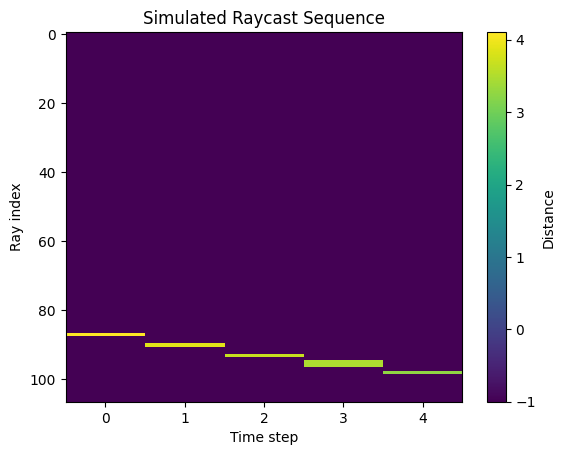

In [ ]:
def visualize_rays(ray_seq):
    plt.imshow(ray_seq.T, aspect='auto', cmap='viridis')
    plt.xlabel("Time step")
    plt.ylabel("Ray index")
    plt.title("Simulated Raycast Sequence")
    plt.colorbar(label="Distance")
    plt.show()

visualize_rays(X[0])



# Model Definition

In [6]:
class VisualCNN(nn.Module):
    def __init__(self, num_rays):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32, 2)  # Predict x, y position

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, R)
        features = self.cnn(x).squeeze(-1)  # (B, 32)
        return self.fc(features)  # (B, 2)

class MotionLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)  # Predict x, y, vx, vy

    def forward(self, x):
        out, _ = self.lstm(x)  # (B, T, H)
        return self.fc(out[:, -1])  # (B, 4)

class GatingNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, cnn_feat, lstm_feat):
        x = torch.cat([cnn_feat, lstm_feat], dim=-1)
        return self.fc(x)  # scalar gate between 0 and 1

class GatedFusionModel(nn.Module):
    def __init__(self, num_rays):
        super().__init__()
        self.visual_cnn = VisualCNN(num_rays)
        self.motion_lstm = MotionLSTM()
        self.gating_net = GatingNetwork(input_size=6)  # [x,y] from CNN + [x,y,vx,vy] from LSTM

    def forward(self, rays_seq, pos_seq):
        cnn_input = rays_seq[:, -1, :]  # last frame (B, R)
        lstm_input = pos_seq  # (B, T, 2)

        v_spatial = self.visual_cnn(cnn_input)  # (B, 2)
        l_spatial = self.motion_lstm(lstm_input)  # (B, 4)

        g = self.gating_net(v_spatial, l_spatial)  # (B, 1)
        s_pos = g * v_spatial + (1 - g) * l_spatial[:, :2]  # final position
        s_vel = l_spatial[:, 2:]  # only LSTM predicts velocity
        return torch.cat([s_pos, s_vel], dim=-1)  # (B, 4)

# Training

In [ ]:
X_tensor = torch.tensor(X_rays, dtype=torch.float32)
Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
Y_target = torch.tensor(np.concatenate([Y_pos_final, Y_vel], axis=1), dtype=torch.float32)

dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_target)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = GatedFusionModel(num_rays=X_rays.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

losses = []
for epoch in range(50):
    epoch_loss = 0
    for xb_rays, xb_pos, yb in loader:
        pred = model(xb_rays, xb_pos)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

Epoch 0: Loss = 0.9454
Epoch 1: Loss = 0.6897
Epoch 2: Loss = 0.6206
Epoch 3: Loss = 0.5799
Epoch 4: Loss = 0.5511
Epoch 5: Loss = 0.5278
Epoch 6: Loss = 0.5097
Epoch 7: Loss = 0.4954
Epoch 8: Loss = 0.4816
Epoch 9: Loss = 0.4715
Epoch 10: Loss = 0.4623
Epoch 11: Loss = 0.4536
Epoch 12: Loss = 0.4465
Epoch 13: Loss = 0.4393
Epoch 14: Loss = 0.4328
Epoch 15: Loss = 0.4272
Epoch 16: Loss = 0.4210
Epoch 17: Loss = 0.4147
Epoch 18: Loss = 0.4098
Epoch 19: Loss = 0.4047


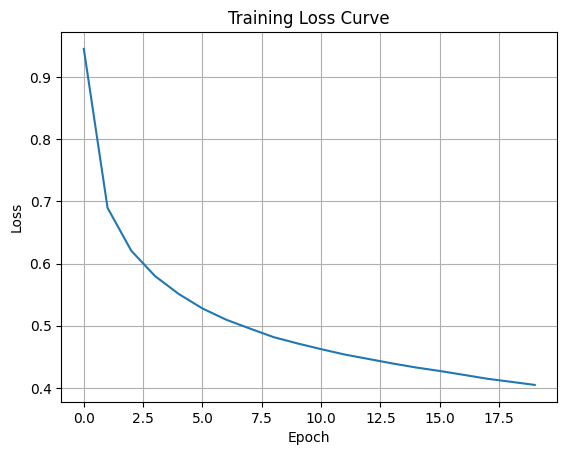

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Gated Fusion Training Loss")
plt.grid(True)
plt.show()

# 5. Eval

In [14]:
X_test = np.load('data/collected_test_data_input.npy')
y_test = np.load('data/collected_test_data_output.npy')

In [ ]:
model.eval()
model.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(X_test))
    test_ray = torch.tensor(X_test[idx:idx+1], dtype=torch.float32)
    test_pos = torch.tensor(Y_test[idx:idx+1], dtype=torch.float32)
    prediction = model(test_ray, test_pos).numpy()[0]

    print("Predicted (x, y, vx, vy):", prediction)
    print("Ground truth (x, y, vx, vy):", np.concatenate([Y_pos_final[idx], Y_vel[idx]]))


Predicted: [ 0.41719028  0.9099009  -3.9722855   0.5076891 ]
Ground Truth: [ 0.54564544  0.9435534  -3.97647731  0.4462975 ]


C:\Users\griff\AppData\Local\Temp\ipykernel_23792\1883937767.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  input_tensor = torch.tensor([test_seq], dtype=torch.float32)


In [50]:
true_vel = []
pred_vel = []
true_pos = []
pred_pos = []

model.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(X_test) - 1, 30)

    for i in idx:
        test_seq = X_test[i]
        test_target = y_test[i]
        input_tensor = torch.tensor([test_seq], dtype=torch.float32)
        prediction = model(input_tensor)[0].numpy()

        true_pos.append(test_target[:2])
        true_vel.append(test_target[2:])
        pred_pos.append(prediction[:2])
        pred_vel.append(prediction[2:])
    # print("Predicted:", prediction)
    # print("Ground Truth:", test_target)  # [x, y, vx, vy]

In [51]:
x_coords_true_vel, y_coords_true_vel = zip(*true_vel)
x_coords_pred_vel, y_coords_pred_vel = zip(*pred_vel)
x_coords_true_pos, y_coords_true_pos = zip(*true_pos)
x_coords_pred_pos, y_coords_pred_pos = zip(*pred_pos)

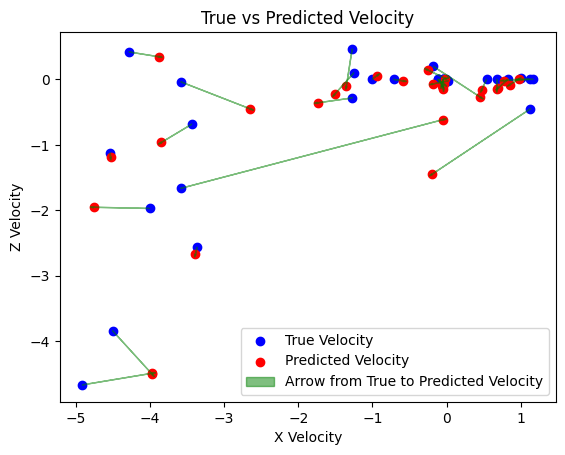

In [52]:
plt.scatter(x_coords_true_vel, y_coords_true_vel, color='blue', label='True Velocity')
plt.scatter(x_coords_pred_vel, y_coords_pred_vel, color='red', label='Predicted Velocity')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_vel[i], y_coords_true_vel[i], x_coords_pred_vel[i]-x_coords_true_vel[i], y_coords_pred_vel[i]-y_coords_true_vel[i], 
              head_width=0.02, head_length=0.05, fc='green', ec='green', alpha=0.5, label="Arrow from True to Predicted Velocity" if i == 0 else "")
plt.title("True vs Predicted Velocity")
plt.xlabel("X Velocity")
plt.ylabel("Z Velocity")
plt.legend()


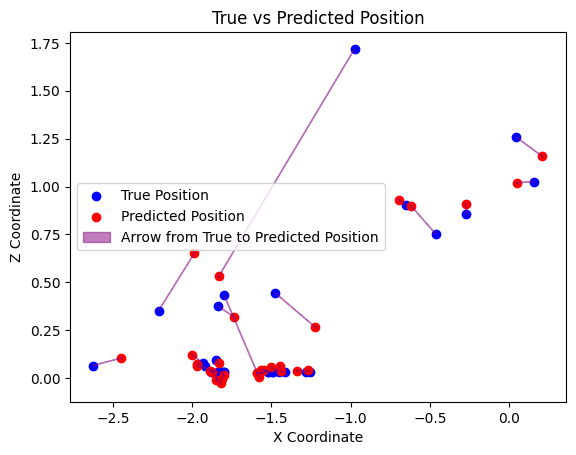

In [53]:
plt.scatter(x_coords_true_pos, y_coords_true_pos, color='blue', label='True Position')
plt.scatter(x_coords_pred_pos, y_coords_pred_pos, color='red', label='Predicted Position')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_pos[i], y_coords_true_pos[i], x_coords_pred_pos[i]-x_coords_true_pos[i], y_coords_pred_pos[i]-y_coords_true_pos[i], 
              head_width=0.005, head_length=0.01, fc='purple', ec='purple', alpha=0.5, label="Arrow from True to Predicted Position" if i == 0 else "")
plt.title("True vs Predicted Position")
plt.xlabel("X Coordinate")
plt.ylabel("Z Coordinate")
plt.legend()